# CPSC 533V: Policy Gradients and Proximal Policy Optimization (PPO)

---

## Submission Information

- Complete the assignment by editing and executing the associated Python files.
- Task 1 should be completed in the notebook, i.e. include your answers under each question.
- Task 2-4 are coding and experiment questions. Copy and paste your results (screenshots and logs) in the notebook.  You should also copy completed code into this notebook and paste under the corresponding questions, they should be only a few lines maximum.
- When done, upload the completed Jupyter notebook (ipynb file) on canvas.
- **We recommend working in groups of two**. List your names and student numbers below (if you use a different name on Canvas).

<ul style="list-style-type: none; font-size: 1.2em;">
<li>Name (and student ID): Izzy Yixin Zhang (97182935)</li>
<li>Name (and student ID):</li>
</ul>

*As always, you are encouraged to discuss your ideas and approaches with other students, even if you are not working as a group.*

## Assignment Background

This assignment is on vanilla policy gradients (VPG) methods and Proximal Policy Optimization (PPO).
You will be implementing the loss functions for vanilla policy gradients (VPG), running some experiments on it, and then implementing clipped-PPO policy gradients and its loss function.  The change for PPO is simple and it yields efficient-to-compute stable policy updates, making PPO one of the most widely used DeepRL algorithms today.


Goals:
- To understand policy gradient RL and to implement the relevant training losses, for both discrete and continuous action spaces
- To observe the sensitivity issues that plague vanilla policy gradients
- To understand and implement the PPO clipping objective and to observe how it addresses these issues

External resources:
- [Sutton's Book Chapter 13: Policy Gradients](http://incompleteideas.net/book/the-book-2nd.html)
- [Andrej Karpathy's post on RL in general and policy gradients specifically](http://karpathy.github.io/2016/05/31/rl/)
- [OpenAI's Spinning Up for coverage of policy gradients and PPO](https://spinningup.openai.com/en/latest/)
- [PPO paper](https://arxiv.org/pdf/1707.06347.pdf)
- [Matthew's StackOverflow Post on PPO](https://stackoverflow.com/questions/46422845/what-is-the-way-to-understand-proximal-policy-optimization-algorithm-in-rl/50663200#50663200)

## Task 0: Preliminaries



### Dependencies

In addition to dependencies from past assignments, we will learn to use TensorBoard to view our experiment results. 
```
pip install tensorboard
```

If you want to experiment with LunarLander instead of Cartpole, you'll also need to install the box2d environment.
```
pip install 'gymnasium[box2d]'
```

### Debugging


You can include:  `import ipdb; ipdb.set_trace()` in your code and it will drop you to that point in the code, where you can interact with variables and test out expressions.  We recommend this as an effective method to debug the algorithms.

---

### Quick recap of policy gradients

The idea is that we create a **differentiable policy** $\pi$ to be optimized so as to yield actions that yield high return.  To optimize the policy, we generate samples in the environment and we use those to compute a "modulated gradient" usable for gradient ascent on the policy parameters.  The modulated gradient consists of two terms: (1) the bare policy gradient term $\text{log}(\pi_\theta(a_t | s_t))$,  and the (2) reward/advantage modulator term $A_t$.  Note that $a_t$ is the action that was actually chosen and sent to the environment.  In PyTorch, we implement this modulated gradient by multiplying the two terms together in the following loss function and then calling backward on it:
$$L^{PG}(\theta) = \text{log}(\pi_\theta(a_t | s_t)) * A_t$$

The policy gradient term by itself indicates the direction required to move the policy parameters to *make the action that we chose more probable*.  By itself, this does nothing useful, if applied equally to all samples.  However, by multiplying this gradient by the advantage $A_t$, the full modulated gradient tells us how to move in the direction that makes good actions more probably and bad actions less probable.  When $A_t$ is large in absolute value, we should change the probability a lot. When $A_t$ is negative, we should make that action less likely.  This lets us use a non-differentiable reward signal to modulate the policy's gradient.

Here is a reference of a full vanilla policy gradient algorithm from OpenAI's Spinning Up resources.  This uses a critic value function $V$ trained to predict return.

![alt text](https://spinningup.openai.com/en/latest/_images/math/262538f3077a7be8ce89066abbab523575132996.svg)

---

## Task 1: Getting up to speed [14pts]
We have provided template code to get started.
For an overview, the files are: `models.py`, `pg_buffer.py`, `main.py`, `utils.py`.  You need only modify `main.py`, but you may modify the others if you so choose.
- `model.py` has the implementation of the networks and the action distributions we will use 
- `pg_buffer.py` has the implementation of the policy gradient buffer (similar to a replay buffer, but only for the most recent on-policy data)
- `main.py` has the (incomplete) implementation of the policy gradient losses and training loop
- `utils.py` utility (helper) functions


### `models.py`

#### 1.a.  Read `models.py` [1pts]
Read through `models.py` and describe what the contained classes do and how they are used.  Include notes that also help support your own understanding and any questions you have.  If you find an anwer to these questions later, you can write them here. Pay attention to the distributions used and how they are parameterized, and also what is different between data collection and optimization time.

#### 1.b.  Categorical distribution [1pts]
Imagine we have 4 possible actions {0, 1, 2, 3}, and our network outputs logits of `[-2.5, 0.9, 2.4, 3.7]`.  How does `Categorical` convert this into a valid probability distribution, i.e., having probabilities that sum to 1?  What mathematical function is used and what would be the probabilities returned in this case?

#### 1.c. Gradient of Categorical distribution [3pts]
Continuing from the previous question, assume that we sample from that distribution such that we choose the action corresponding to index 2 (i.e., $a_t = 2$).  Now we want to compute the log prob gradient of this action.  What would be the value of this gradient with respect to all of the logit inputs? In other words, what is $\nabla_{\text{logits}} \text{log}(\pi(a_t))$ if $\pi$ is our Categorical?

You can solve this either by deriving the gradient on paper using your answer from 1.b. or by empirically computing it with code.  In the latter case, you may use the pseudocode below, but you must write a mathematical expression for how the logit gradients are related to the probabilities of the Categorical (`c.probs`).

```
logits = torch.nn.Parameter(torch.tensor([-2.5, 0.9, 2.4, 3.7]))   # imagine these came from the output of the network
c = Categorical(logits=logits)
a_t = torch.tensor(2)  # imagine this came from c.sample()
logp = c.log_prob(a_t)
logp.backward()
print(logits.grad)
```

#### 1.d. Gaussian actor [2pts]
Now imagine we have a continuous action space with 2 actions, and our network outputs a mu of `[0.0, 1.2]`.  Then assume we sampled from that distribution to get $a_t = [0.1, 1.0]$.  What is $\nabla_\mu \text{log}(\pi_\mu(a_t))$ if $\pi$ is our Normal?  Give the value for this case, and write a mathematical expression for the gradient value in general, as a function of $\mu$ and $a_t$.

#### 1.e. Meaning of these gradients [1pts]
For both continuous and discrete actions, what are these gradients telling us to do, in terms of the logits and the mus and the actions chosen?  

###  `pg_buffer.py`

This code implements a buffer used to store the data we acculumate so we can process it in a batch.
Notably, it also computes GAE-Lambda Advantages. To answer the questions below, you should first skim the GAE paper, including at least the abstract and Equation 1 with the different options for $\Psi$ (`psi`): https://arxiv.org/pdf/1506.02438.pdf.  


#### 1.f  Why use GAE-lambda? [1pts]
What is the main argument from the GAE paper about why one should use the Advantage function, (rather than sum of discounted future reward for example) for our choice of $A_t$?

#### 1.g  Paper to code correspondence [1pts]
See the `finish_path` function.  In which line of the GAE algorithm (pg 8) would you call it? And which equation in the GAE paper does the `adv_buf` line (`pg_buffer.py:61`) correspond to?
 
### 1.3 `main.py`

#### 1.h. Read `main.py` [2pts]

Read through the code and write down any notes that help your understanding of what is going on, as well as any questions you have.

#### 1.i. Order of data collection and updating [1pts]
Note the order that we collect data and run optimization in.  How many steps do we collect data before running an update (w/ default args)?  Then how many optimization steps do we run in `update` by default?

#### 1.i. End of episode handling [1pts]
Describe how the episode terminals / timeouts are handled

In [5]:
import torch
from torch.distributions.categorical import Categorical
logits = torch.nn.Parameter(torch.tensor([-2.5, 0.9, 2.4, 3.7]))   # imagine these came from the output of the network
c = Categorical(logits=logits)
a_t = torch.tensor(2)  # imagine this came from c.sample()
logp = c.log_prob(a_t)
logp.backward()
print(logits.grad)

tensor([-0.0015, -0.0455,  0.7959, -0.7489])


In [7]:
from torch.distributions.normal import Normal
import numpy as np
mu = torch.nn.Parameter(torch.tensor([0.0, 1.2]))
std = np.exp(-0.5)
pi = Normal(mu, std)
logp_a = pi.log_prob(torch.tensor([0.1, 1.0])).sum(axis=-1)
logp_a.backward()
mu.grad

tensor([ 0.2718, -0.5437])

## ANSWERS for Task 1

#### 1.a 
class Network: specifies number of layers, initializes weights and bias to 0, applies ReLU activation function; 

class DiscreteActor: produces categorical distribution pi using logits of the action probabilities, computes log prob of action to take using pi; 

class GaussianActor: similar to DiscreteActor, except pi follows normal distribution with mu computed from obs and std = exp(-0.5); 

class ActorCritic: initializes action based on action space data type, samples action from pi and computes the log probaility of the sampled action, get value estimate v. 

#### 1.b 
the function takes exponentes of each logit and normalized them by deviding them with their sum. The function is softmax. In this case, the output would be [0.00151975 0.04553794 0.20408691 0.7488554]
```
import numpy as np
test = [-2.5, 0.9, 2.4, 3.7]
def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0)
print(softmax(test))
```

#### 1.c
$\frac{\partial \log \pi(a_t)}{\partial \text{logits}k} = \delta_{a_t,k} - p_k$ where $\delta_{a_{t},k}$ is 1 if $k=a_t$ and 0 otherwise. $p_k$ we can get from 1.b. 

therefore, the output would be [0-0.00151975, 0-0.04553794, 1-0.20408691, 0-0.7488554] = [-0.0015, -0.0455,  0.7959, -0.7489]

#### 1.d
$\nabla_\mu \log \pi_\mu(a_t) = \frac{(a_t - \mu)}{\sigma^2}$ with $\mu = [0.0, 1.2]$ and $a_t = [0.1, 1.0]$ 

If we assume $\sigma = 1$, then $\nabla_\mu \log \pi_\mu(a_t) = [0.1, -0.2]$

In code, log_std = -0.5, therefore $\sigma = exp(-0.5) \approx 0.06065$, $\nabla_\mu \log \pi_\mu(a_t) = [0.272, -0.544]$
```
from torch.distributions.normal import Normal
import numpy as np
mu = torch.nn.Parameter(torch.tensor([0.0, 1.2]))
std = np.exp(-0.5) # or assume std = 1
pi = Normal(mu, std)
logp_a = pi.log_prob(torch.tensor([0.1, 1.0])).sum(axis=-1)
logp_a.backward()
mu.grad
```

#### 1.e
The gradients are telling us to adjust the parameters to increase the likelihood of selecting actions that lead to higher rewards. For discrete actions, the gradient tells us to move increase the logit of favorable actions and decrease the others. For continuous actions, the gradient tells us to move mu towards favorable actions and away from detrimental actions. 

#### 1.f
The sum of discounted rewards provides an unbiased but high-variance estimate for policy gradients. And such variance does not scale well with time. GAE intends to reduce variance by introducing a tolerable level of bias to achieve fast and more stable learning. 

#### 1.g
I would call the function in 
$``\text{Compute } \hat{A}t = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V \text{ at all timesteps}."$

The `adv_buf` line correponds to $\hat{A}t = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V$


#### 1.h
code workflow: 1) set up environment, action and observation space, ActorCritic model, epoch size, buffer, logging and visualization, loss function and extra info, value loss, and optimizer; 2) set up update function that retrieves data from buffer, calculates current policy loss and value loss, updates policy parameters, and logs loss values; 3) for each step in each epoch, collect action, value estimate, and log probability of the curren tobservation, takes action a, then retrive, update and save the next observation, reward, and additional information. 

#### 1.i
by default, 1000 steps are run before update. We run 4 optimization steps for the policy network (train_pi_iters = 4), We run 40 optimization steps for the value network (train_v_iters = 40). 

The episode termanates when episode length reaches a limit (timeout) or when episode is done. bootstrap is used if the episode ended by reaching timeout or end of epoch. 

---

## Task 2: Implementing Policy Gradient Losses [10pts]

Now you will implement the vanilla policy gradient losses.  This includes the policy gradient loss $L^{PG}$ as well as a critic loss $L^{V}$, where the critic will be used to compute better advantages. You can reference any external sources you would like, but we suggest first trying to implement the losses without these.

$$L^{PG}(\theta) = \text{log}(\pi_\theta(a_t | s_t)) A_t$$

$$L^{V}(\phi) = (V_{\phi}(s_t) - R_t)^2$$

In this homework, choose between CartPole and LunarLander, although experiment with other environments if you are feeling adventurous.  We recommend LunarLander because it is fun and more challenging than CartPole, and good policies are generally quick to learn.  It takes around 10 minutes to reach interesting behavior on a decent computer, and should be fine for this homework.  However, if you find that it is taking too long to train, you can switch to CartPole.  LunarLander also has both discrete and continuous versions so you can try both modes.

- Fill in the TODOs in the `compute_loss_pi` and `compute_loss_v` functions.
- Run your code and make sure it is correct.

The figure below gives examples of the learning curves that you can expect to see with a correct implementation.  This is LunarLander-v2 performance run with the default arg settings.  Note that watching the losses is not as helpful as it is supervised learning. Losses in RL can be deceiving.  They can be increasing, while your policy is still improving a lot.  The reverse can also happen.  They are mostly good to watch as a sanity check and diagnostic. Also note that entropy is a less obvious, but very helpful metric to watch in RL, especially for discrete action spaces.  It should not stay at its maximum, nor should it drop very quickly; it should somewhat gradually decrease as shown in the figure. 

![example curves](https://i.imgur.com/Ut7R1C9.png)
You might see something slightly different due to small differences in your implementation.  Command to run: `tensorboard --logdir=logs/`

In [1]:
# ANSWERS for Task 2

# Copy your completed functions (or relevant sections) from main.py and paste them here
# loss_pi = - (logp * psi).mean()
# loss_v = ((v - ret) ** 2).mean()

---

## Task 3: Experimenting with the code [11pts]
 
Once you verify your losses are correct by seeing that your policy starts learning, you will run some experiments.  For this, we have created several command line options that can be used to vary parameters, as well as a logging system that prints to stdout and logs scalars (and optionally gifs) to TensorBoard.  

#### 3.a.  REINFORCE vs. GAE-Lambda [3pts]

As the GAE paper discusses, there are many possible choices for advantage term to use in the policy gradient.  One of the first ones imagined is the discounted future return (`future_return` in the code).  This choice leads to the REINFORCE algorithm (excerpted from the [Sutton book Chapter 13](http://incompleteideas.net/book/the-book-2nd.html) for your reference (where $G$ is discounted future return):

![REINFORCE](https://i.imgur.com/WzyIzgg.png)
You will compare REINFORCE advantage (discounted return) to GAE lambda advantage.  Before you run the experiment, write down what you think will happen.  Why might REINFORCE do better or why might GAE-Lambda do better for this environment? Then run the two following experiments and measure the difference.  You should run them for at least 100 epochs, and maybe more if you want.  Then write down what happened and include a TensorBoard screenshot with both the results.

```
python3 main.py --psi_mode=future_return --prefix=logs/3a/ --epochs=100  # you can make these longer if you want
```

```
python3 main.py --psi_mode=gae --prefix=logs/3a/ --epochs=100
```

In [2]:
# ANSWERS for Task 3.a

# Describe your predictions. Why might REINFORCE do better or why might GAE-Lambda do better for this environment?
# Answer: REINFORCE will give unbiased estimate of the expected returns, but GAE-Lambda may improve learning such that it converges faster and is more stable. 
#  
# Write down what actually happened
# Include any screenshots, logs, etc



screenshot of the tensorboard log (orange: future_return; blue: gae) indicates that REINFORCE does slightly better at episodic return than GAE. GAE is significantly better at converging to smaller policy loss, which is a sign of better stability than REINFORCE. 
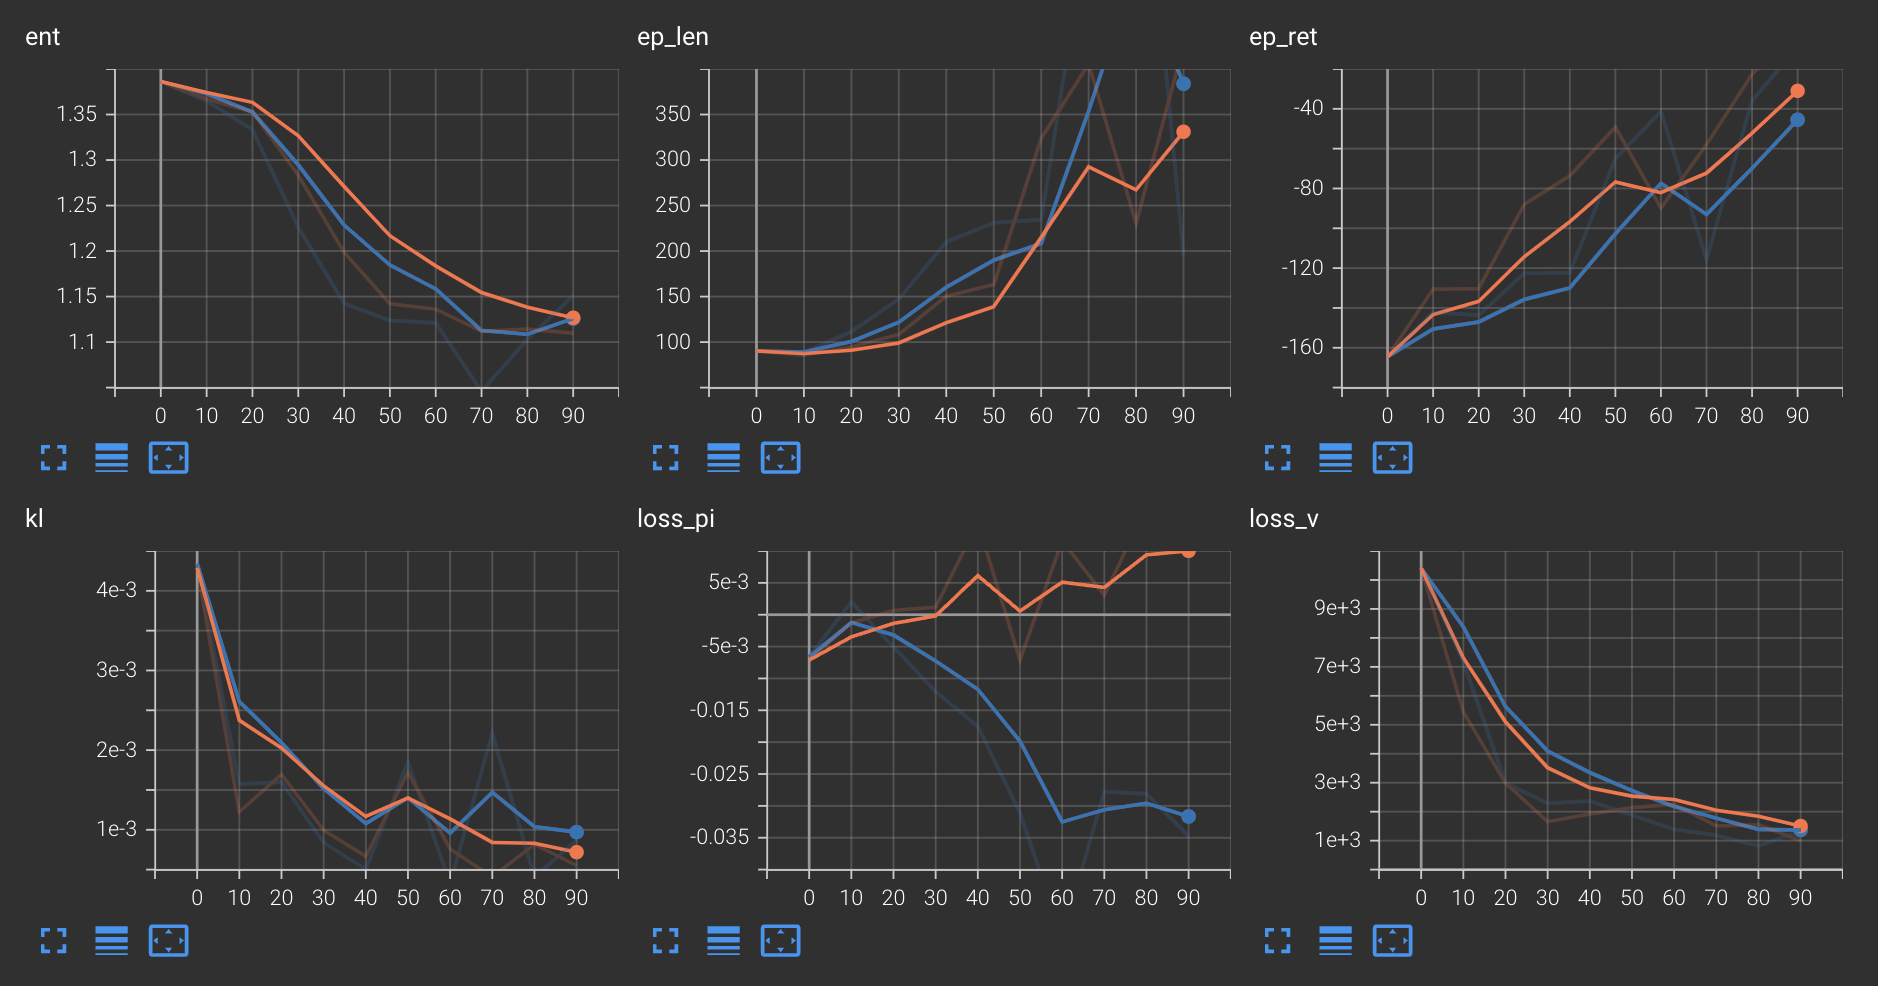


#### 3.b.  Running with different numbers of policy training steps / vanilla policy gradient failure [3pts]

One issue of vanilla policy gradient methods is that they are fairly unstable.
In general one cannot run too many update steps for the most recent data because the policy will then overfit to that local data.
It will update too much based on that local gradient estimate and it will eventually cause more harm than good.
Once this happens, it is very difficult to recover.

This is a well known issue that motivated the development of TRPO and PPO, and you are you going to test this issue for yourself. By default, our code only runs 4 policy iterations during each update phase. What happens if you try to run more?  Try the following experiments, include a screenshot and write some thoughts you had about this.  Anything expected or unexpected?  (Note you will rerun these experiments with PPO in a minute)

```
python3 main.py --prefix=logs/3b/ --train_pi_iters=4  --epochs=150 # you can just also keep your results from part a 
```

```
python3 main.py --prefix=logs/3b/ --train_pi_iters=10 --epochs=150  
```

```
python3 main.py --prefix=logs/3b/ --train_pi_iters=20 --epochs=150
```

In [3]:
# ANSWERS for Task 3.b

# Describe anything expected or unexpected in the experiment
# Include any screenshots, logs, etc

below is the tensorboard log with light blue being 4iters, magenta being 10iters and green being 20 iters. It is expected to see that the learning become more unstable with increasing iterations per epoch. However, I did not expect it to overfit so much on the local gradient. 
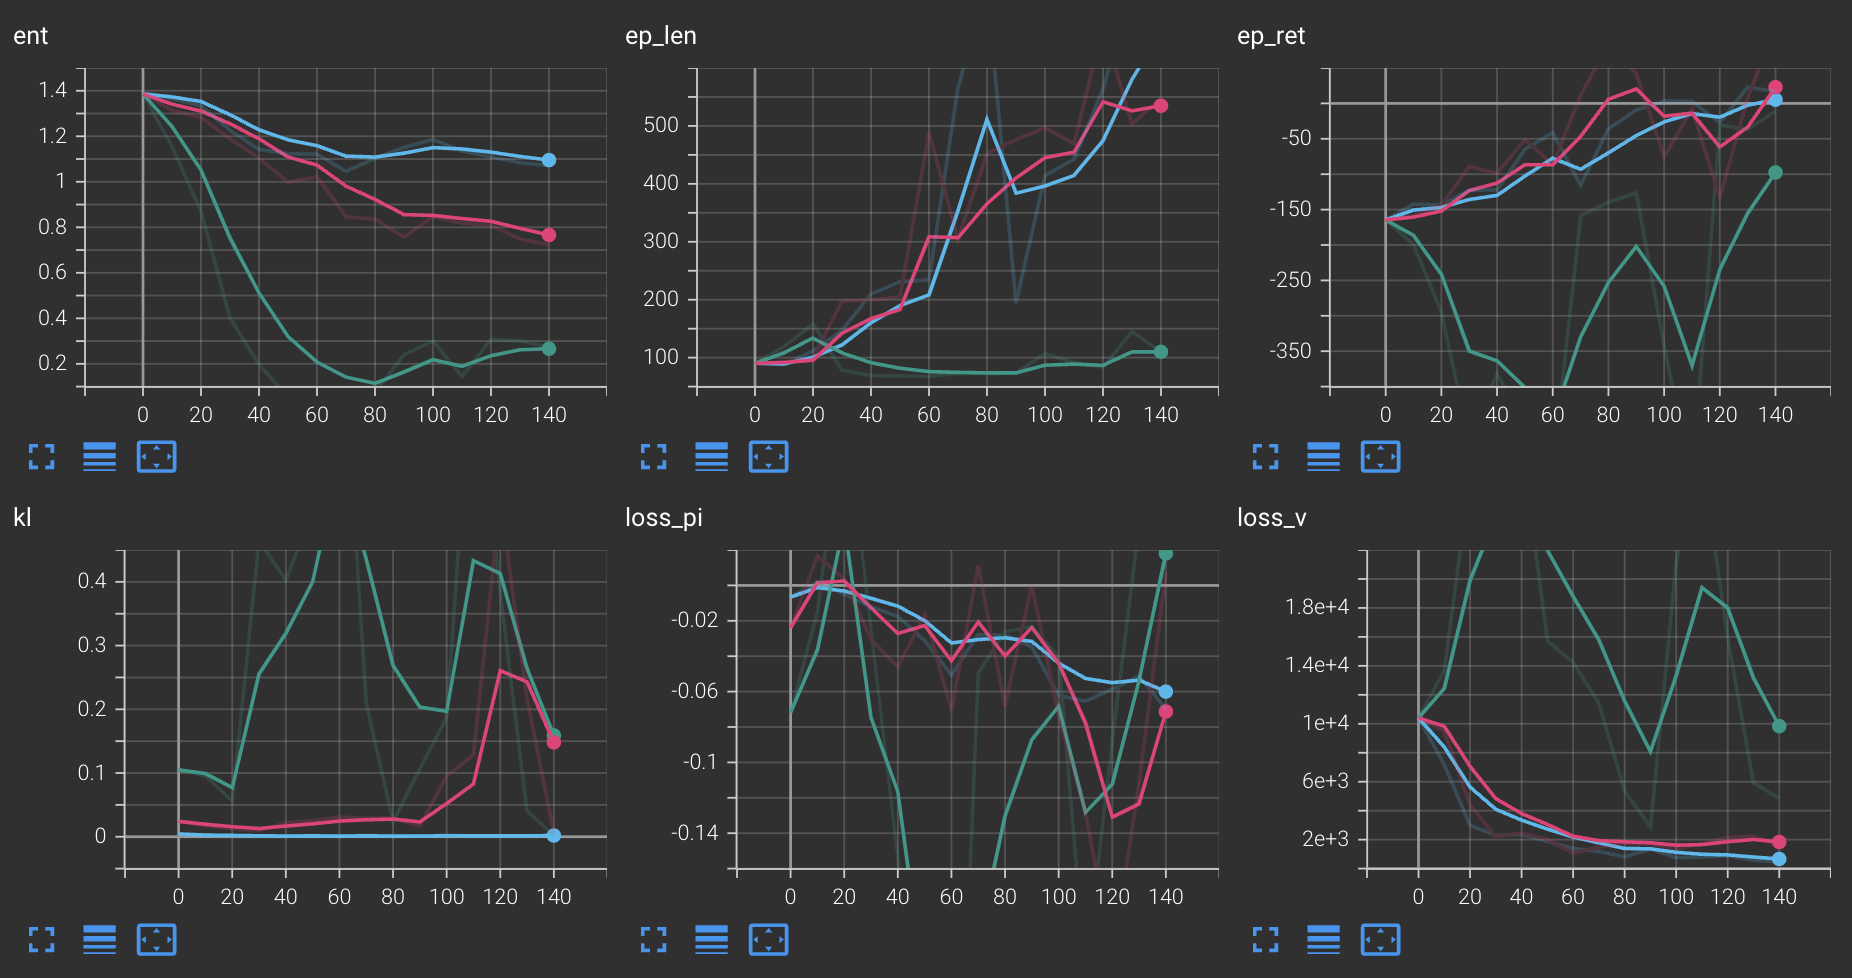

#### 3.c.  Design your  own experiment(s) [5pts]

NOTE: you can defer this until after implementing the PPO loss if you wish

Now you get to design your own experiments.  Perhaps you are curious about how the learning rate affects things or how a different network would work.  This is your chance to experiment with whatever you think would be interesting to try.
You are free to make any modifications to the code that you would like to run your experiments.

Here is a further list of ideas:
- network arch, activations
- learning rates
- implementing other $\psi$ versions (e.g., #6)
- continuous environment.  comparing how LunarLander does against LunarLanderContinuous
- effect of gamma parameter
- effect of lambda parameter
- how much better performance is if we don't sample from the mean (deterministic forward pass, for evaluation)
- how different random seeds compare
- anything else that you think of

Describe what you are testing, and your predictions about what is going to happen.
Then run the experiment and report the results, including screenshots.

In [4]:
# ANSWERS for Task 3.c

# Describe what you are testing and your predictions
# Include any screenshots, logs, etc

#### change learning rates (defalt --pi_lr=1e-3 --v_lr=1e-4)
hypothesis: higher learning rate learns faster but more unstable, lower learning rate learns slower
obvervations: blue (lowest learning rate), magenta (default), red (highest). The result matches my hypothesis, such that both lowest and default learning rate yield stable learning, with default having relatively higher reward and lower loss. The one highest learning rate becomes unstable. 
``python3 main.py --prefix=logs/3c/ --train_pi_iters=4  --pi_lr=1e-2 --v_lr=1e-3 --epochs=150``
``python3 main.py --prefix=logs/3c/ --train_pi_iters=4  --pi_lr=1e-4 --v_lr=1e-5 --epochs=150``
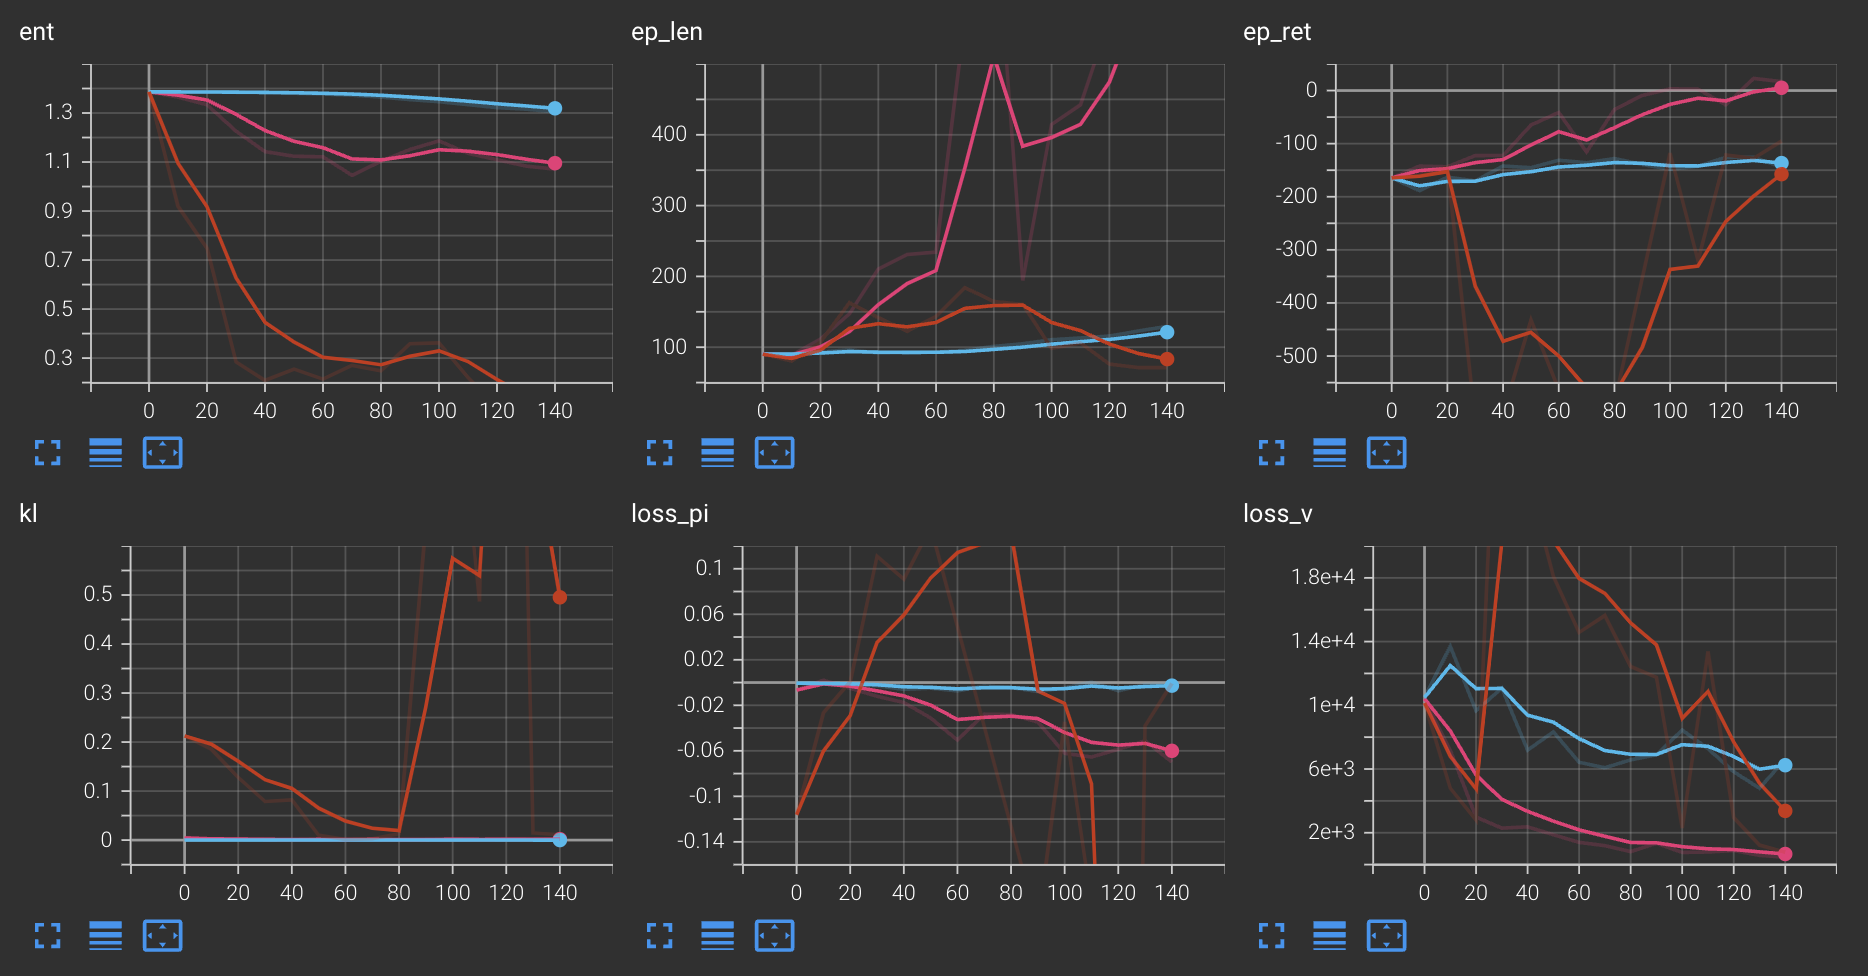

#### changing seed
hypothesis: changing seed should have some, but not big effect on learning
observations: magenta (default seed), orange (different seed). They are similar. 
``python3 main.py --prefix=logs/3c/ --seed=1234 --epochs=150``
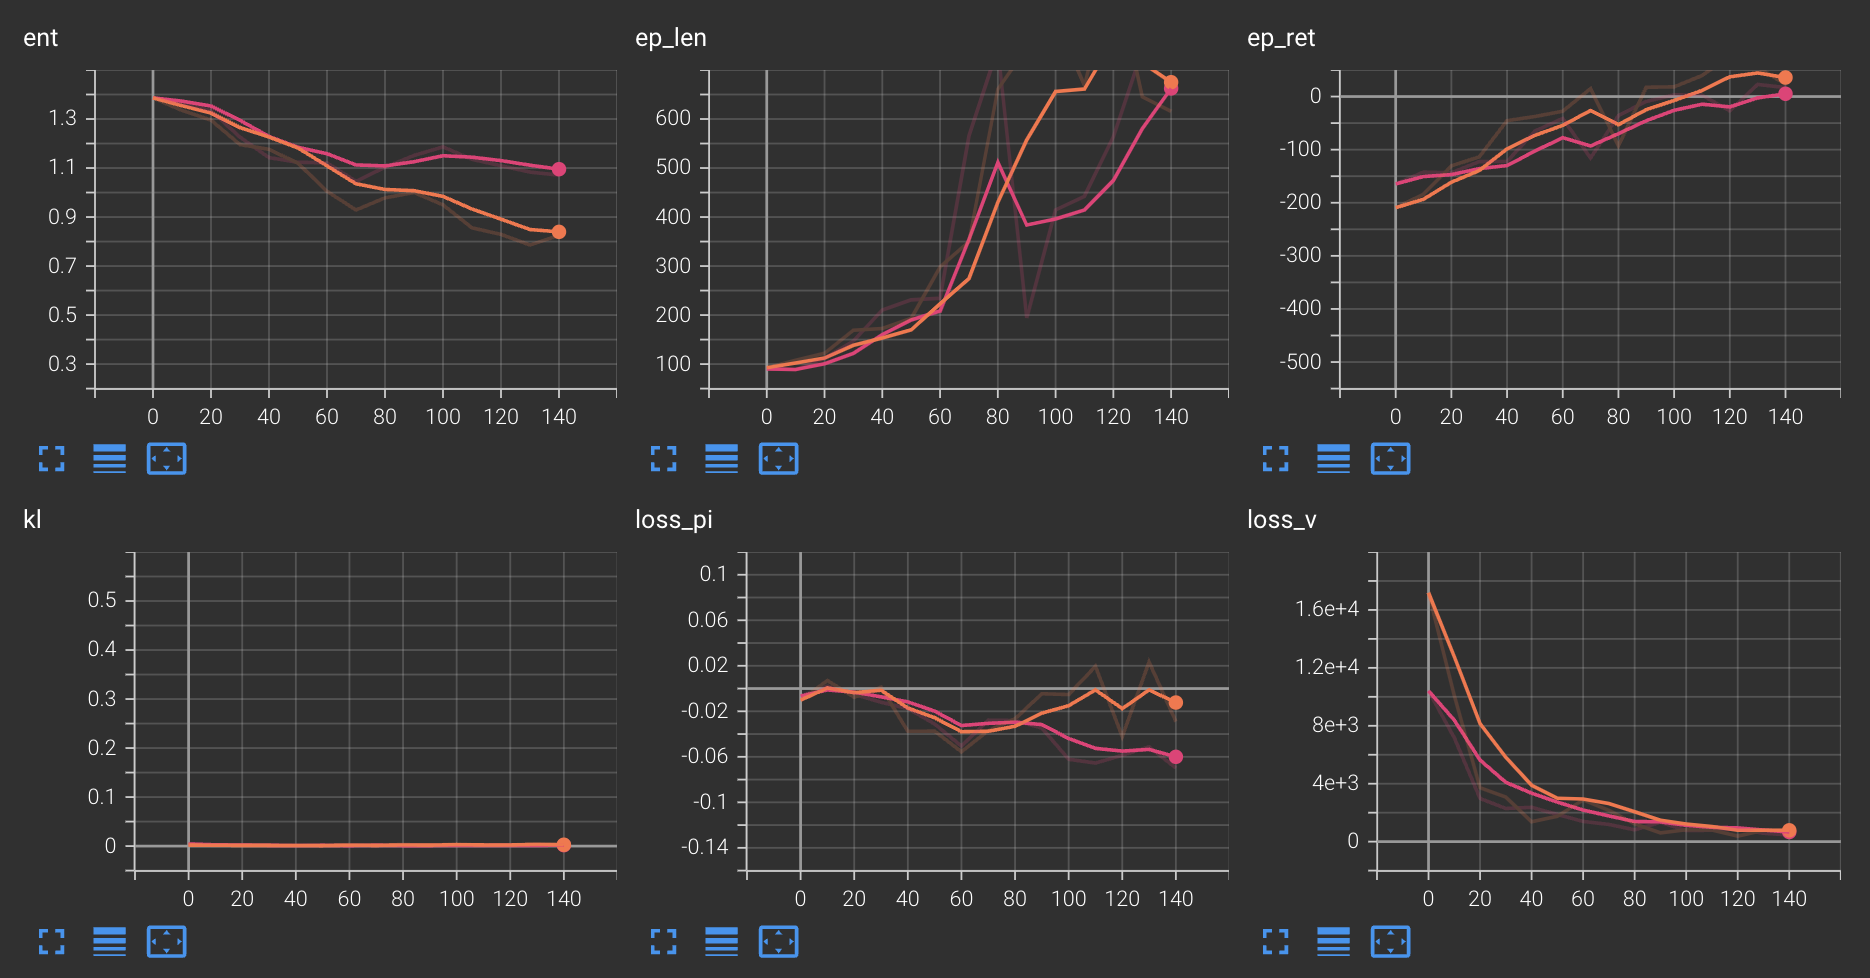

---

## Task 4: Trying out the PPO clipping objective [10pts]

The following are useful resources for understanding PPO:
- [OpenAI's Spinning Up for coverage of policy gradients and PPO](https://spinningup.openai.com/en/latest/)
- [PPO paper](https://arxiv.org/pdf/1707.06347.pdf)
- [Matthew's StackOverflow Post on PPO](https://stackoverflow.com/questions/46422845/what-is-the-way-to-understand-proximal-policy-optimization-algorithm-in-rl/50663200#50663200)


Now implement the PPO clipped loss objective in the `compute_loss_pi` function. It is a small fix (only a few lines) to our policy gradients implementation.  After you see that it is learning, by running the command below, you will then compare it to VPG.
```
python3 main.py --loss_mode=ppo
```

This would have been problematic before, but now the algorithm should stay fairly stable:
```
python3 main.py --loss_mode=ppo --prefix=logs/4/ --train_pi_iters=20 --epochs=150
```
vs.

```
python3 main.py --loss_mode=vpg --prefix=logs/4/ --train_pi_iters=20 --epochs=150
```


Record the results of what happened and consider including some screenshots.  You are free to run and include any other tests that you found interesting.  You can also try to further tune PPO and find hyperparameters that make it work better.

In [5]:
# ANSWERS for Task 4
# elif args.loss_mode == 'ppo':
#     # TODO (Task 4): implement clipped PPO loss
#     ratio = torch.exp(logp - logp_old)
#     clip_ratio = args.clip_ratio
#     unclipped = ratio*psi
#     clipped = torch.clamp(ratio, 1-clip_ratio, 1+ clip_ratio)* psi
#     loss_elements = torch.min(unclipped, clipped)
#     loss_pi = -loss_elements.mean()

# Copy your completed function (or relevant sections) here
# Include any screenshots, logs, etc
# Describe anything else you have tried

Image below indicates the tensorboard logs of ppo (orange) vs vpg (blue). We see that vpg is very unstable and overfits to the training episodes. PPO has a consistent increase in reward per episode and decrease in value loss. the policy loss is stable, however, not minimizing for PPO. 
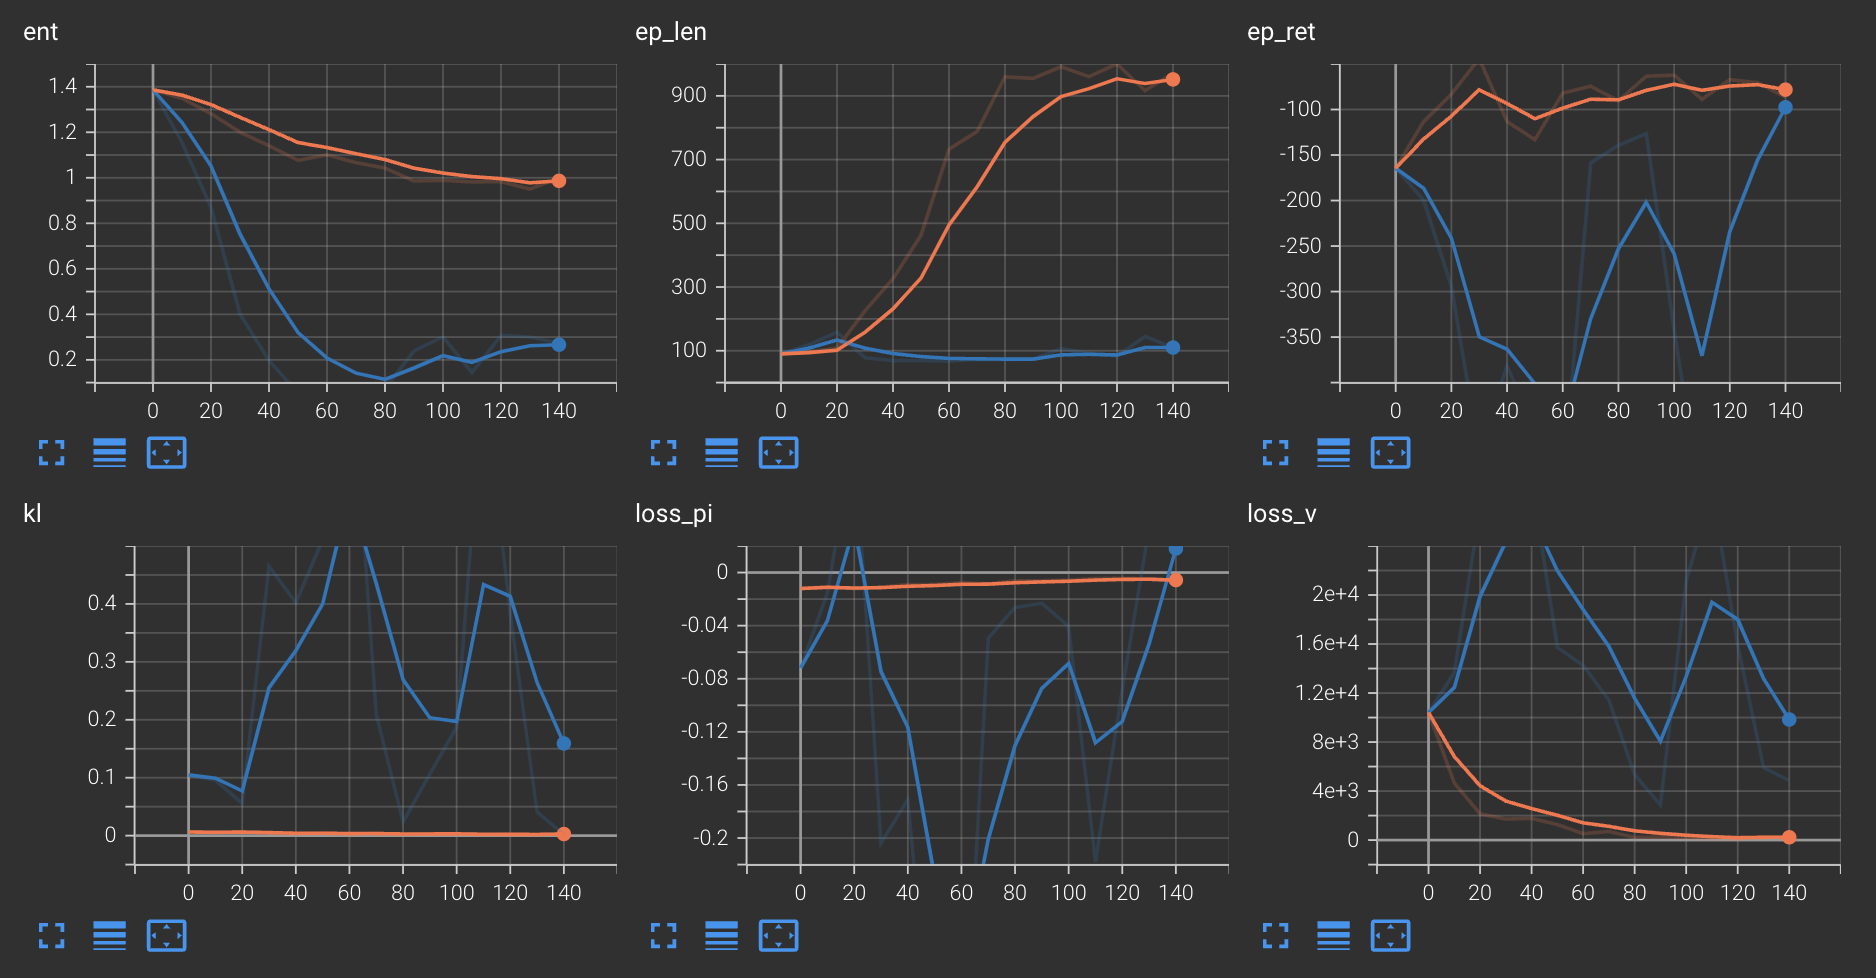

#### try lower gamma (gamma = 0.9)
hypothesis: it may learn faster
observation: orange (default gamma = 0.99), red (gamma = 0.9). they yield similar results. value loss for lower gamma starts smaller. 
``python3 main.py --loss_mode=ppo --gamma=0.90 --prefix=logs/4/gamma0.90/ --epochs=150``
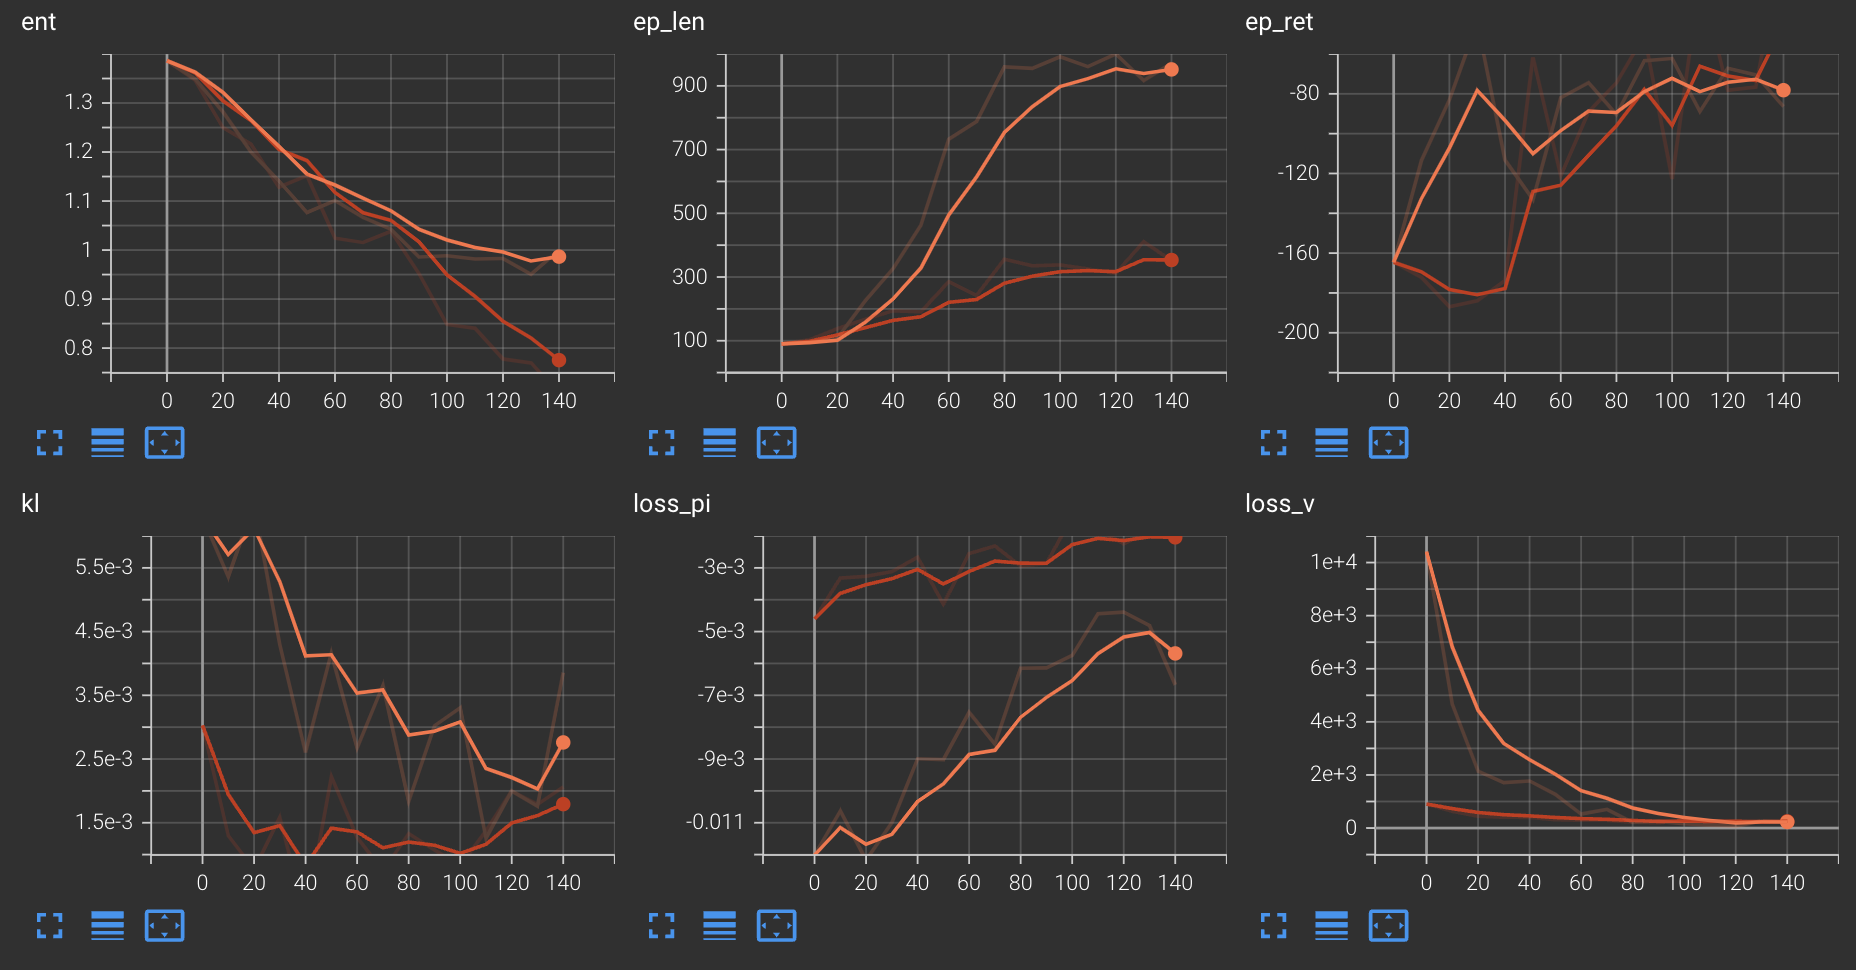

#### try lower lambda (lambda = 0.8)
hypothesis: it may learn faster
observation: orange (default lam = 0.97), blue (lambda = 0.8). reward per episode increases faster for smaller lambda, but value loss for small lambda is constantly higher. 
``python3 main.py --loss_mode=ppo --lam=0.80 --prefix=logs/4/lam0.80/ --epochs=150``
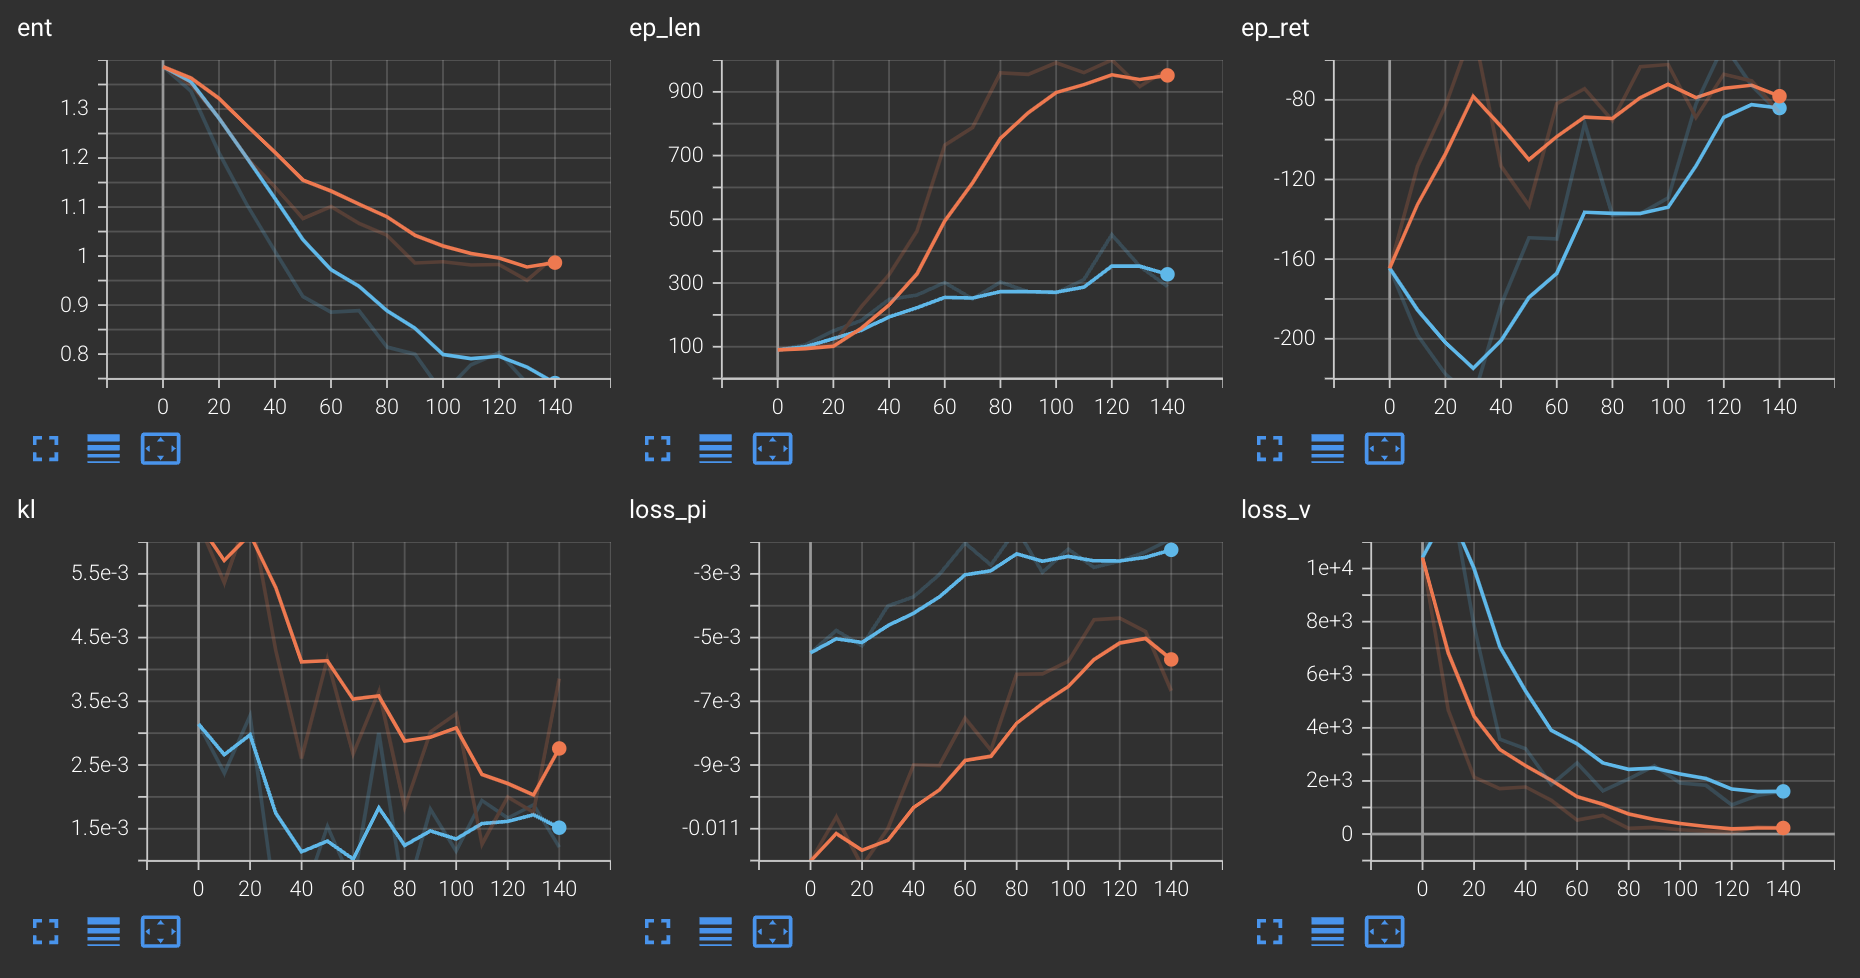

---

## Task 5: Optional

#### 5.1 Fully solving LunarLander

During initial testing, you likely did not fully solve LunarLander.  An optimal reward is about 300.  Your first bonus task is to adapt your implementation, as needed, to achieve this high reward.  This likely involves parameter tuning, implementing learning rate annealing, and maybe some observation normalization.

#### 5.2 Implementing parallelized environments

A major bottleneck right now is that we are only collecting data with 1 agent at a time.  Most modern algorithm implementations use many parallel episodic evaluations to collect data.  This greatly speeds up training and is a practical necessity if you want to use these algorithms to solve new problems.  Your second bonus task is to implement parallelized environment data collection.  One fairly easy way to do this is to use Gymnasium's `AsyncVectorEnv`.  This runs N environments each in their own process.  To use it, you will have to make a few slight modifications to your data collection code to handle stacks of observations and actions.

Documentation (see tests for usage): https://gymnasium.farama.org/api/vector/#gymnasium.vector.AsyncVectorEnv

#### 5.3 New environments

Your third bonus task is to try solving the PyBullet environments (or Mujoco if you want to get a free license).  `HalfCheetah` is a good place to start as one of the easier control tasks.  See the [Bullet code here](https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/examples/enjoy_TF_HalfCheetahBulletEnv_v0_2017may.py) for how to make the bullet envs.


```
# Example environment usage
import gymnasium as gym
import pybullet_envs
env = gym.make("HalfCheetahBulletEnv-v0")
env.render(mode="human")

obs = env.reset()
while True:
    act = env.action_space.sample()
    obs, rew, done, info = env.step(act)

```

#### 5.4 Setting up MuJoCo

MuJoCo is free as of October 18, 2021 ([News](https://deepmind.com/blog/announcements/mujoco)). There are now official and open-source [Python bindings for MuJoCo](https://github.com/google-deepmind/mujoco/tree/main).  This bonus task is about installing and running MuJoCo on your machine.  MuJoCo is slightly faster than PyBullet, so you might consider using it for your projects.